# **A | IMPORTING PHASE**

In [1]:
import re
import string
import nltk
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# **B | LOADING DATA PHASE**




In [3]:
# Load the IMDB dataset
max_words = 10000  # Top 10,000 words
max_len = 100      # Maximum sequence length

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_words)

# Get the word index
word_index = imdb.get_word_index()

# Reverse the word index to map indices to words
reverse_word_index = {index: word for word, index in word_index.items()}

def decode_review(sequence):
    # Decode a single sequence to text
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in sequence])

# Example: Decode the first training review
print(decode_review(X_train[0]))

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the w

# **C | DATA PREPROCESSING PHASE**

In [5]:

# ✅ Step 2: Load IMDb Dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_words)

# ✅ Step 3: Decode Integer Sequences to Words
word_index = imdb.get_word_index()
reverse_word_index = {value + 3: key for key, value in word_index.items()}
reverse_word_index[0] = '<PAD>'
reverse_word_index[1] = '<START>'
reverse_word_index[2] = '<UNK>'
reverse_word_index[3] = '<UNUSED>'

def decode_review(encoded_review):
    return ' '.join([
        reverse_word_index.get(i, '')
        for i in encoded_review
        if reverse_word_index.get(i, '') not in ('<PAD>', '<START>', '<UNK>', '<UNUSED>')
    ])


train_texts = [decode_review(review) for review in X_train]
test_texts = [decode_review(review) for review in X_test]

# ✅ Step 4: Preprocessing Function with POS Lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tagged_tokens = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    return ' '.join(lemmatized)




film brilliant casting location scenery story direction everyones really suit part played could imagine robert amazing actor director father come scottish island love fact real connection film witty remark throughout film great brilliant much bought film soon release would recommend everyone watch fly fish amaze really cried end sad know say cry film must good definitely also two little boy play norman paul brilliant child often leave list think star play grow big profile whole film child amaze praise do dont think whole story lovely true someone life share u


In [7]:
# ✅ Step 5: Apply Preprocessing to All Reviews
train_texts_preprocessed = [preprocess_text(text) for text in train_texts]
test_texts_preprocessed = [preprocess_text(text) for text in test_texts]

# ✅ Example Output
print(train_texts_preprocessed[0])

film brilliant casting location scenery story direction everyones really suit part played could imagine robert amazing actor director father come scottish island love fact real connection film witty remark throughout film great brilliant much bought film soon release would recommend everyone watch fly fish amaze really cried end sad know say cry film must good definitely also two little boy play norman paul brilliant child often leave list think star play grow big profile whole film child amaze praise do dont think whole story lovely true someone life share u


In [9]:
# ✅ Step 1: Initialize Tokenizer
tokenizer = Tokenizer(num_words=10000)

# Fit tokenizer on the training texts
tokenizer.fit_on_texts(train_texts_preprocessed)

# ✅ Step 2: Convert Texts to Sequences
X_train_seq = tokenizer.texts_to_sequences(train_texts_preprocessed)
X_test_seq = tokenizer.texts_to_sequences(test_texts_preprocessed)

# ✅ Step 3: Apply Padding
X_train_padded = pad_sequences(X_train_seq, maxlen=100)
X_test_padded = pad_sequences(X_test_seq, maxlen=100)

# ✅ Example output
print(X_train_padded[0])

[   0    0    0    0    0    0    0    0    0    0    3  438 2845  853
 1206   15  356 3551   19  950   59 2362   42  602  484  911   49   62
  217   36 3595  923   37  102   66 1411    3 1627 2763  384    3   24
  438   25 6324    3  426  261   18  236  222   14  736 2188  577   19
 6685   27  507   30   26  718    3  127    9  329   29   47   53  267
   39 3057  600  438  174  320   91  684   20   73   39  549   83 5735
  139    3  174  577 1828  138   35   20  139   15 1165  198  197   43
  880   81]


# **D | BUILD TRAINING MODEL PHASE**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stop])


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.4956 - loss: 0.7248 - val_accuracy: 0.5468 - val_loss: 0.6873
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.5342 - loss: 0.6929 - val_accuracy: 0.6296 - val_loss: 0.6591
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.6123 - loss: 0.6462 - val_accuracy: 0.7822 - val_loss: 0.4659
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.7770 - loss: 0.4829 - val_accuracy: 0.8118 - val_loss: 0.4297
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.8151 - loss: 0.4203 - val_accuracy: 0.8054 - val_loss: 0.4492
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.8346 - loss: 0.3924 - val_accuracy: 0.7914 - val_loss: 0.4759
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.8577 - loss: 0.3488 - val_accuracy: 0.7988 - val_loss: 0.4582


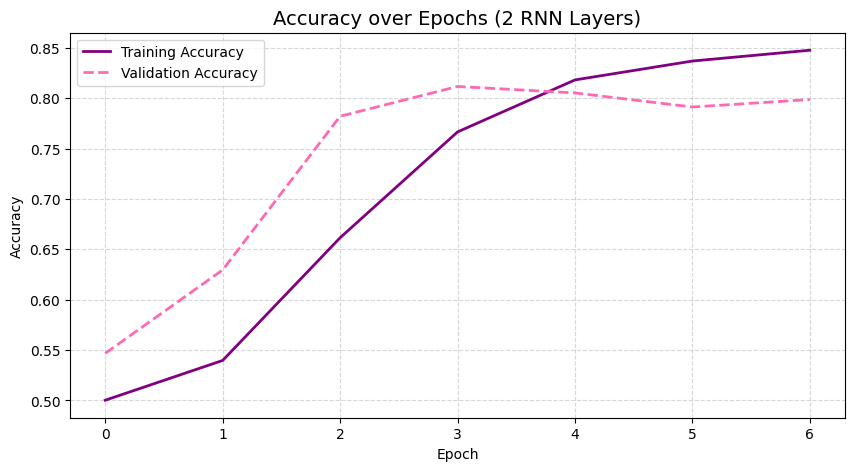

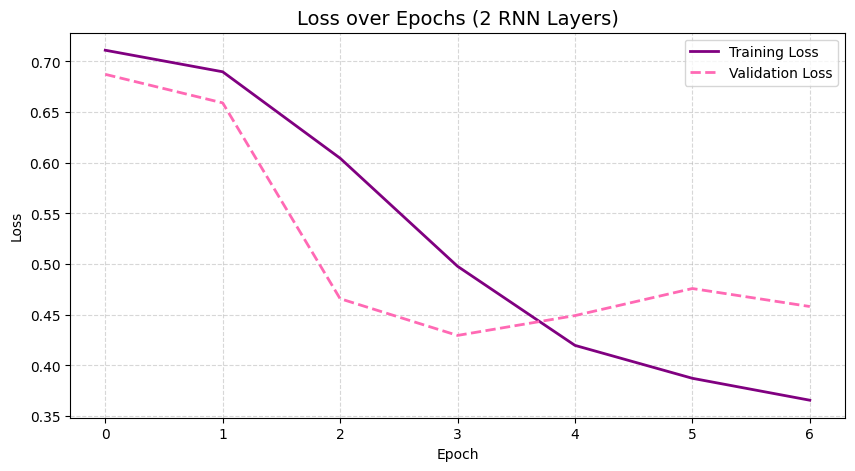

In [12]:
import matplotlib.pyplot as plt

# -----------------------------
# 🎯 Accuracy Plot
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='purple', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='hotpink', linestyle='--', linewidth=2)
plt.title('Accuracy over Epochs (2 RNN Layers)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -----------------------------
# 🎯 Loss Plot
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='purple', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='hotpink', linestyle='--', linewidth=2)
plt.title('Loss over Epochs (2 RNN Layers)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [14]:
# Define the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(SimpleRNN(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(SimpleRNN(128, kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"L2 RNN - Test Accuracy: {accuracy:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - accuracy: 0.5099 - loss: 0.9291 - val_accuracy: 0.5654 - val_loss: 0.8008
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 282ms/step - accuracy: 0.7104 - loss: 0.6839 - val_accuracy: 0.8350 - val_loss: 0.4976
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - accuracy: 0.8783 - loss: 0.4151 - val_accuracy: 0.8414 - val_loss: 0.4666
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 260ms/step - accuracy: 0.9064 - loss: 0.3382 - val_accuracy: 0.8318 - val_loss: 0.4716
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step - accuracy: 0.9283 - loss: 0.2769 - val_accuracy: 0.8376 - val_loss: 0.4865
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step - accuracy: 0.9367 - loss: 0.2430 - val_accuracy: 0.8290 - val_loss: 0.4903
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8357 - loss: 0.4738
L2 RNN - Test Accuracy: 0.8379


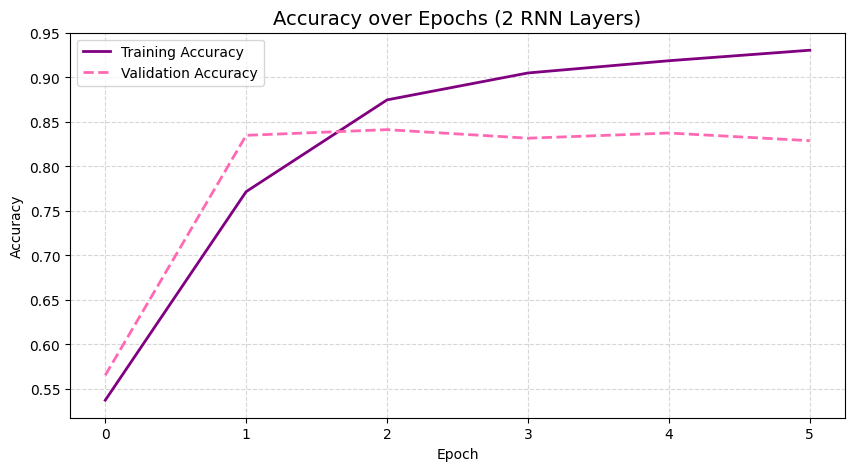

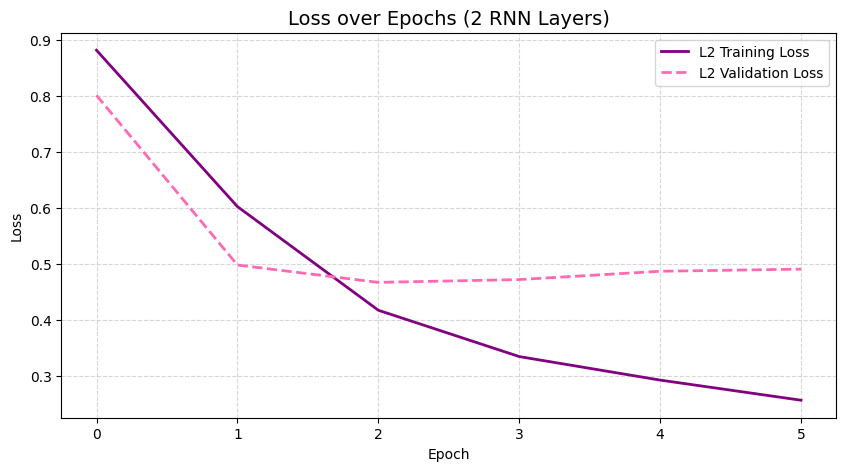

In [15]:
import matplotlib.pyplot as plt

# -----------------------------
# 🎯 Accuracy Plot
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='purple', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='hotpink', linestyle='--', linewidth=2)
plt.title('Accuracy over Epochs (2 RNN Layers)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -----------------------------
# 🎯 Loss Plot
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='L2 Training Loss', color='purple', linewidth=2)
plt.plot(history.history['val_loss'], label='L2 Validation Loss', color='hotpink', linestyle='--', linewidth=2)
plt.title('Loss over Epochs (2 RNN Layers)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# **E | EVALUATING PHASE**

In [17]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5826 - loss: 0.6552
Test Loss: 0.6541
Test Accuracy: 0.5809
